In [5]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import Dropdown
from IPython.display import display
from ipywidgets import *
import modules

In [6]:
#Get all valid year ranges and associated species

set_type_desc = []
all_xy = glob.glob('/work/home/db876/xy/*/*/*/*/LSP_stats.nc')
valid_xy_obs = glob.glob('/work/home/db876/xy/*/*/*/obs_*/LSP_stats.nc')
valid_xy_model = [f for f in all_xy if 'obs_' not in f.split('/')[-2]]
obs_spec = [i.split('/')[5] for i in valid_xy_obs]
obs_range = [i.split('/')[7] for i in valid_xy_obs]
obs_set = [i.split('/')[-2] for i in valid_xy_obs]
set_type_desc=np.append(set_type_desc,['obs']*len(obs_spec))

modelxy_spec = [i.split('/')[5] for i in valid_xy_model]
modelxy_range = [i.split('/')[7] for i in valid_xy_model]
modelxy_set = [i.split('/')[-2] for i in valid_xy_model]
set_type_desc=np.append(set_type_desc,['modelxy']*len(modelxy_spec))

valid_grid = glob.glob('/work/home/db876/grid/*/*/*/*/LSP_stats.nc')
modelgrid_spec = [i.split('/')[5] for i in valid_grid]
modelgrid_range = [i.split('/')[7] for i in valid_grid]
modelgrid_set = [i.split('/')[-2] for i in valid_grid]
set_type_desc=np.append(set_type_desc,['modelgrid']*len(modelgrid_spec))

all_filenames = np.array(valid_xy_obs+valid_xy_model+valid_grid)
all_year_ranges = np.array(obs_range+modelxy_range+modelgrid_range)
all_spec = np.array(obs_spec+modelxy_spec+modelgrid_spec)
all_set = np.array(obs_set+modelxy_set+modelgrid_set)
unique_year_ranges = np.unique(all_year_ranges)

year_range_dict = {}
for yr in unique_year_ranges:
    spec_cut = np.unique(all_spec[all_year_ranges == yr])
    year_range_dict[yr] = list(spec_cut) 
    
#all_year_ranges = np.array(['2005_2010','2005_2010','2005_2010','2005_2010','2006_2012','2006_2012','2006_2012','2006_2012','2006_2012','2006_2012'])
#all_spec = np.array(['O3','O3','O3','NO','NO','NO','NO','CO','NO2','NO2'])
#all_set = np.array(['obs_H','GEOS-Chem','GEOS-Chem','obs_H','GEOS-Chem','GEOS-Chem-FP','GFDLAM3','obs_H','obs_H','GFDLAM3'])
#set_type_desc = np.array(['obs','modelxy','modelgrid','obs','modelxy','modelxy','modelgrid','obs','obs','modelgrid'])
#unique_year_ranges = np.array(['2005_2010','2006_2012'])
#year_range_dict = {'2005_2010': ['O3','NO'],'2006_2012': ['NO','CO','NO2']}

In [7]:
#Setup widgets and associated callbacks

#*Associated with each year range is a list of species that populate x,y,z species columns (in a dict)
#*Associated with each species are types of datasets for that species (i.e obs/modelxy/modelgrid)

#create year range dropdown box
year_sel = Dropdown(description='Year Range',options=list(unique_year_ranges))
#setup callback for when year range is changed
def change_year_sel(change):
    print 'year change'
    current_year_range = year_sel.value
    #when year range is changed associations need to be changed
    #1. need to change associated x,y,z species
    x_spec_sel.options = year_range_dict[current_year_range]
    y_spec_sel.options = year_range_dict[current_year_range]
    z_spec_sel.options = year_range_dict[current_year_range]
    x_spec_sel.value = x_spec_sel.options[0]
    y_spec_sel.value = y_spec_sel.options[0]
    z_spec_sel.value = z_spec_sel.options[0]
    
year_sel.observe(change_year_sel, names="value")
    
#create x,y,z species dropdown boxes, default species options associated with current year range value
x_spec_sel = Dropdown(description='X',options=year_range_dict[year_sel.value])
y_spec_sel = Dropdown(description='Y',options=year_range_dict[year_sel.value])
z_spec_sel = Dropdown(description='Z',options=year_range_dict[year_sel.value])

#setup callbacks for when x,y or z species are changed
def change_x_spec_sel(change):
    print 'x spec'
    
    #1. update types
    x_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
    x_types_desc = list(x_types_desc[np.argsort(ind)]) 
    
    #y_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value)],return_index=True)
    #y_types_desc = list(y_types_desc[np.argsort(ind)])  
    
    #z_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value)],return_index=True)
    #z_types_desc = list(z_types_desc[np.argsort(ind)])  
    
    y_types_desc = list(y_type_sel.options)
    z_types_desc = list(z_type_sel.options)
    current_y_type_desc = y_type_sel.value
    current_z_type_desc = z_type_sel.value
    
    #deal with rules in updating types when changing species
    #3 same species
    if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value):
        print '3 same species'
        #Cannot be 3 modelgrids but all other options are fine
        if (current_y_type_desc == 'modelgrid') or (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                x_types_desc.remove('modelgrid')
            except:
                pass
    
    #3 different species
    elif (x_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != z_spec_sel.value) & (y_spec_sel.value != z_spec_sel.value):
        print '3 diff species'
        #Must be only 1 obs or modelxy type
        #if y or z are obs or modelxy, x must be grid
        if (current_y_type_desc != 'modelgrid') or (current_z_type_desc != 'modelgrid'):
            #if modelgrid in x_types_desc, otherwise set blank
            if 'modelgrid' in x_types_desc:
                x_types_desc = ['modelgrid']
            else:
                x_types_desc = ['']
        #if y & z both modelgrid then x must be obs or modelxy
        elif (current_y_type_desc == 'modelgrid') & (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                x_types_desc.remove('modelgrid')
            except:
                pass

    #1,2 species
    else:
        print '1,2 species'
        #Must be only 1 obs or modelxy type
        #if y or z are obs or modelxy, x must be grid
        if (current_y_type_desc != 'modelgrid') or (current_z_type_desc != 'modelgrid'):
            #if modelgrid in x_types_desc, otherwise set blank
            if 'modelgrid' in x_types_desc:
                x_types_desc = ['modelgrid']
            else:
                x_types_desc = ['']
        
        #if y or z both modelgrid then x must be obs or modelxy
        elif (current_y_type_desc == 'modelgrid') & (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                x_types_desc.remove('modelgrid')
            except:
                pass
    
    if len(x_types_desc) == 0:
        x_types_desc = [''] 
    x_type_sel.options=x_types_desc
    y_type_sel.options=y_types_desc
    z_type_sel.options=z_types_desc
    #try:
    #x_type_sel.value = x_type_sel.options[0]
    #except:
    #    pass
    #try:
    #y_type_sel.value = y_type_sel.options[0]
    #except:
    #    pass
    #try:
    #z_type_sel.value = z_type_sel.options[0]
    #except:
    #    pass

    #2. update sets 
    if x_type_sel.options != ['']:
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value) & (set_type_desc == x_type_sel.value)])
        x_set_sel.options=sets
    else:
        x_set_sel.options = ['']
    x_set_sel.value = x_set_sel.options[0]
    #3. refresh groups
    x_group_sel.value = x_group_sel.options[0]
    #4. refresh params
    x_param_sel.options = param_dict[x_group_sel.value]
    
def change_y_spec_sel(change):
    print 'y spec'
    #1. update types
    y_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value)],return_index=True)
    y_types_desc = list(y_types_desc[np.argsort(ind)])
    
    #x_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
    #x_types_desc = list(x_types_desc[np.argsort(ind)])  
    
    #z_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value)],return_index=True)
    #z_types_desc = list(z_types_desc[np.argsort(ind)]) 
    
    x_types_desc = list(x_type_sel.options)
    z_types_desc = list(z_type_sel.options)
    current_x_type_desc = x_type_sel.value
    current_z_type_desc = z_type_sel.value
    
    #3 same species
    if (y_spec_sel.value == x_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
        #Cannot be 3 modelgrids but all other options are fine
        if (current_x_type_desc == 'modelgrid') or (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                y_types_desc.remove('modelgrid')
            except:
                pass
    
    #3 different species
    elif (y_spec_sel.value != x_spec_sel.value) & (y_spec_sel.value != z_spec_sel.value) & (x_spec_sel.value != z_spec_sel.value):
        #Must be only 1 obs or modelxy type
        #if x or z are obs or modelxy, y must be grid
        if (current_x_type_desc != 'modelgrid') or (current_z_type_desc != 'modelgrid'):
            #if modelgrid in y_types_desc, otherwise set blank
            if 'modelgrid' in y_types_desc:
                y_types_desc = ['modelgrid']
            else:
                y_types_desc = ['']
        #if x & z both modelgrid then y must be obs or modelxy
        elif (current_x_type_desc == 'modelgrid') & (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                y_types_desc.remove('modelgrid')
            except:
                pass

    #1,2 species
    else:
        #Must be only 1 obs or modelxy type
        #if x or z are obs or modelxy, y must be grid
        if (current_x_type_desc != 'modelgrid') or (current_z_type_desc != 'modelgrid'):
            #if modelgrid in x_types_desc, otherwise set blank
            if 'modelgrid' in y_types_desc:
                y_types_desc = ['modelgrid']
            else:
                y_types_desc = ['']
        
        #if x or z both modelgrid then y must be obs or modelxy
        elif (current_x_type_desc == 'modelgrid') & (current_z_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                y_types_desc.remove('modelgrid')
            except:
                pass
        
    if len(y_types_desc) == 0:
        y_types_desc = ['']
    y_type_sel.options=y_types_desc
    x_type_sel.options=x_types_desc
    z_type_sel.options=z_types_desc    
    y_type_sel.value = y_type_sel.options[0]

    #2. update sets 
    if y_type_sel.options != ['']:
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value) & (set_type_desc == y_type_sel.value)])
        y_set_sel.options=sets
    else:
        y_set_sel.options = ['']
    y_set_sel.value = y_set_sel.options[0]
    #3. refresh groups
    y_group_sel.value = y_group_sel.options[0]
    #4. refresh params
    y_param_sel.options = param_dict[y_group_sel.value]
    
def change_z_spec_sel(change):
    print 'z spec'
    #1. update types
    z_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value)],return_index=True)
    z_types_desc = list(z_types_desc[np.argsort(ind)])
    
    #x_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
    #x_types_desc = list(x_types_desc[np.argsort(ind)])  
    
    #y_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value)],return_index=True)
    #y_types_desc = list(y_types_desc[np.argsort(ind)]) 
    
    x_types_desc = list(x_type_sel.options)
    y_types_desc = list(y_type_sel.options)
    current_x_type_desc = x_type_sel.value
    current_y_type_desc = y_type_sel.value
    
    #3 same species
    if (z_spec_sel.value == x_spec_sel.value) & (z_spec_sel.value == y_spec_sel.value):
        #Cannot be 3 modelgrids but all other options are fine
        if (current_x_type_desc == 'modelgrid') or (current_y_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                z_types_desc.remove('modelgrid')
            except:
                pass
    
    #3 different species
    elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
        #Must be only 1 obs or modelxy type
        #if x or y are obs or modelxy, x must be grid
        if (current_x_type_desc != 'modelgrid') or (current_y_type_desc != 'modelgrid'):
            #if modelgrid in z_types_desc, otherwise set blank
            if 'modelgrid' in z_types_desc:
                z_types_desc = ['modelgrid']
            else:
                z_types_desc = ['']
        #if x & y both modelgrid then z must be obs or modelxy
        elif (current_x_type_desc == 'modelgrid') & (current_y_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                z_types_desc.remove('modelgrid')
            except:
                pass

    #1,2 species
    else:
        #Must be only 1 obs or modelxy type
        #if x or y are obs or modelxy, z must be grid
        if (current_x_type_desc != 'modelgrid') or (current_y_type_desc != 'modelgrid'):
            #if modelgrid in x_types_desc, otherwise set blank
            if 'modelgrid' in z_types_desc:
                z_types_desc = ['modelgrid']
            else:
                z_types_desc = ['']
        
        #if x or y both modelgrid then z must be obs or modelxy
        elif (current_x_type_desc == 'modelgrid') & (current_y_type_desc == 'modelgrid'):
            #remove modelgrid type
            try:
                z_types_desc.remove('modelgrid')
            except:
                pass
        
    if len(z_types_desc) == 0:
        z_types_desc = ['']
    z_type_sel.options=z_types_desc
    x_type_sel.options=x_types_desc
    y_type_sel.options=y_types_desc
    #try:
    z_type_sel.value = z_type_sel.options[0]
    #except:
    #    z_type_sel.value = ''
    #try:
    #x_type_sel.value = x_type_sel.options[0]
    #except:
    #    pass
    #try:
    #y_type_sel.value = y_type_sel.options[0]
    #except:
    #    pass
    
    #update sets 
    if z_type_sel.options != ['']:
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value) & (set_type_desc == z_type_sel.value)])
        z_set_sel.options=sets
    else:
        z_set_sel.options = ['']
    z_set_sel.value = z_set_sel.options[0]
    #3. refresh groups
    z_group_sel.value = z_group_sel.options[0]
    #4. refresh params
    z_param_sel.options = param_dict[z_group_sel.value]

x_spec_sel.observe(change_x_spec_sel, names="value")
y_spec_sel.observe(change_y_spec_sel, names="value")
z_spec_sel.observe(change_z_spec_sel, names="value")

#create x,y,z type dropdown boxes, default options associated with current species (and year range)
xyz_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
xyz_types_desc = list(xyz_types_desc[np.argsort(ind)])
x_type_sel = Dropdown(description='X Type',options=xyz_types_desc)
y_type_sel = Dropdown(description='Y Type',options=xyz_types_desc)
z_type_sel = Dropdown(description='Z Type',options=xyz_types_desc)

#setup callbacks for when x,y or z type are changed
def change_x_type_sel(change):
    print 'x type'
    
    print x_type_sel.options
    
    #cannot have 3 modelgrids
    y_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value)],return_index=True)
    y_types_desc = list(y_types_desc[np.argsort(ind)])
    z_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value)],return_index=True)
    z_types_desc = list(z_types_desc[np.argsort(ind)])
    #y_types_desc = list(y_type_sel.options)
    #z_types_desc = list(z_type_sel.options)
    
    if (y_types_desc == ['']) or ((z_types_desc) == ['']):
        pass
    else:
        if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
            print 'ensuring not grid'
            try:
                z_types_desc.remove('modelgrid')
                if len(z_types_desc) == 0:
                    z_types_desc = ['']
            except:
                pass
            z_type_sel.options=z_types_desc
            #z_type_sel.value = z_type_sel.options[0]
        
        elif (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
            try:
                y_types_desc.remove('modelgrid')
                if len(y_types_desc) == 0:
                    y_types_desc = ['']
            except:
                pass
            y_type_sel.options=y_types_desc
        #update y types if can
        elif (y_types_desc != y_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'): 
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0] 
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0] 
            #2,1 species
            else:
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0] 
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0]
            
        #update z types if can
        elif (z_types_desc != z_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'): 
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (y_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0] 
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0] 
            #2,1 species
            else:
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (y_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0] 
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0]
    
    #update sets 
    if x_type_sel.options != ['']:
        #print year_sel.value,x_spec_sel.value,x_type_sel.value
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value) & (set_type_desc == x_type_sel.value)])
        x_set_sel.options=sets
    else:
        x_set_sel.options = ['']
    x_set_sel.value = x_set_sel.options[0]
    
def change_y_type_sel(change):
    print 'y type'
    
    print x_type_sel.options
    
    #cannot have 3 modelgrids
    x_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
    x_types_desc = list(x_types_desc[np.argsort(ind)])
    z_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value)],return_index=True)
    z_types_desc = list(z_types_desc[np.argsort(ind)])
    #x_types_desc = list(x_type_sel.options)
    #z_types_desc = list(z_type_sel.options)
    
    if (x_types_desc == ['']) or ((z_types_desc) == ['']):
        pass
    else:
        if (y_type_sel.value == 'modelgrid') & (x_type_sel.value == 'modelgrid'):
            try:
                z_types_desc.remove('modelgrid')
                if len(z_types_desc) == 0:
                    z_types_desc = ['']
            except:
                pass
            if len(z_types_desc) > 0:
                z_type_sel.options = z_types_desc
                #z_type_sel.value = z_type_sel.options[0]
        
        elif (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
            try:
                x_types_desc.remove('modelgrid')
                if len(x_types_desc) == 0:
                    x_types_desc = ['']
            except:
                pass
            if len(x_types_desc) > 0:
                x_type_sel.options=x_types_desc
                #x_type_sel.value = x_type_sel.options[0]
        #update x types if can
        elif (x_types_desc != x_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'): 
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                elif (y_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0] 
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0] 
            #2,1 species
            else:
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                elif (y_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0] 
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0] 
        #update z types if can
        elif (z_types_desc != z_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'): 
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (y_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0] 
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0] 
            #2,1 species
            else:
                if (x_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
                    if ('obs' in z_types_desc) or ('modelxy' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (y_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in z_types_desc):
                        z_type_sel.options=z_types_desc
                        z_type_sel.value = z_type_sel.options[0] 
                else:
                    z_type_sel.options=z_types_desc
                    z_type_sel.value = z_type_sel.options[0]
    
    #update sets 
    if y_type_sel.options != ['']:
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value) & (set_type_desc == y_type_sel.value)])
        y_set_sel.options=sets
    else:
        y_set_sel.options = ['']
    y_set_sel.value = y_set_sel.options[0]
    
def change_z_type_sel(change):
    print 'z type'
    #cannot have 3 modelgrids
    x_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value)],return_index=True)
    x_types_desc = list(x_types_desc[np.argsort(ind)])
    y_types_desc,ind = np.unique(set_type_desc[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value)],return_index=True)
    y_types_desc = list(y_types_desc[np.argsort(ind)])
    #x_types_desc = list(x_type_sel.options)
    #y_types_desc = list(y_type_sel.options)
    
    if (x_types_desc == ['']) or ((y_types_desc) == ['']):
        pass
    else:
        if (z_type_sel.value == 'modelgrid') & (x_type_sel.value == 'modelgrid'):
            try:
                y_types_desc.remove('modelgrid')
                if len(y_types_desc) == 0:
                    y_types_desc = ['']
            except:
                pass
            if len(y_types_desc) > 0:
                y_type_sel.options=y_types_desc
                #y_type_sel.value = y_type_sel.options[0]
        
        elif (z_type_sel.value == 'modelgrid') & (y_type_sel.value == 'modelgrid'):
            try:
                x_types_desc.remove('modelgrid')
                if len(x_types_desc) == 0:
                    x_types_desc = ['']
            except:
                pass
            if len(x_types_desc) > 0:
                x_type_sel.options=x_types_desc
                #x_type_sel.value = x_type_sel.options[0]
        #update x types if can
        elif (x_types_desc != x_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'): 
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                elif (y_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0] 
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0] 
            #2,1 species
            else:
                if (y_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in x_types_desc) or ('modelxy' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0]
                elif (y_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in x_types_desc):
                        x_type_sel.options=x_types_desc
                        x_type_sel.value = x_type_sel.options[0] 
                else:
                    x_type_sel.options=x_types_desc
                    x_type_sel.value = x_type_sel.options[0] 
        #update y types if can
        elif (y_types_desc != y_type_sel.options):
            #3 same species
            if (x_spec_sel.value == y_spec_sel.value) & (x_spec_sel.value == z_spec_sel.value) & (y_spec_sel.value == z_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'): 
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0]
            #3 diff species
            elif (z_spec_sel.value != x_spec_sel.value) & (z_spec_sel.value != y_spec_sel.value) & (x_spec_sel.value != y_spec_sel.value):
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0] 
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0] 
            #2,1 species
            else:
                if (x_type_sel.value == 'modelgrid') & (z_type_sel.value == 'modelgrid'):
                    if ('obs' in y_types_desc) or ('modelxy' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0]
                elif (x_type_sel.value != 'modelgrid') or (z_type_sel.value != 'modelgrid'):
                    if ('modelgrid' in y_types_desc):
                        y_type_sel.options=y_types_desc
                        y_type_sel.value = y_type_sel.options[0] 
                else:
                    y_type_sel.options=y_types_desc
                    y_type_sel.value = y_type_sel.options[0]
            
    
    #update sets 
    if z_type_sel.options != ['']:
        sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value) & (set_type_desc == z_type_sel.value)])
        z_set_sel.options=sets
    else:
        z_set_sel.options = ['']
    z_set_sel.value = z_set_sel.options[0]
    
x_type_sel.observe(change_x_type_sel, names="value")
y_type_sel.observe(change_y_type_sel, names="value")
z_type_sel.observe(change_z_type_sel, names="value")
    
#create x,y,z set dropdown boxes,default options associated with current type (species and year range)
sets = list(all_set[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value) & (set_type_desc == x_type_sel.value)])
x_set_sel = Dropdown(description='Set',options=sets)
y_set_sel = Dropdown(description='Set',options=sets)
z_set_sel = Dropdown(description='Set',options=sets)
#def change_x_set_sel(change):
    #if set is altered new file will need to be read in

#create x,y,z group dropdown boxes, groups always constant
groups = ['standard','spring','summer','autumn','winter','day','night']
x_group_sel = Dropdown(description='Group',options=groups)
y_group_sel = Dropdown(description='Group',options=groups)
z_group_sel = Dropdown(description='Group',options=groups)
def change_x_group_sel(change):
    #upon changing group change param options
    x_param_sel.options = param_dict[x_group_sel.value]
    x_param_sel.value = x_param_sel.options[0]
def change_y_group_sel(change):
    #upon changing group change param options
    y_param_sel.options = param_dict[y_group_sel.value]
    y_param_sel.value = y_param_sel.options[0]
def change_z_group_sel(change):
    #upon changing group change param options
    z_param_sel.options = param_dict[z_group_sel.value]
    z_param_sel.value = z_param_sel.options[0]
x_group_sel.observe(change_x_group_sel, names="value")
y_group_sel.observe(change_y_group_sel, names="value")
z_group_sel.observe(change_z_group_sel, names="value")


#create x,y,z param dropdown boxes,params contstant for different groups
param_dict = {'standard':['diurnal_amp','diurnal_ph','seasonal_amp','seasonal_ph','mean','p1','p5','p25','p50','p75','p95','p99','pc_var_daily','pc_var_seasonal','pc_var_full'],'spring':['diurnal_amp','diurnal_ph','mean','p1','p5','p25','p50','p75','p95','p99'],'summer':['diurnal_amp','diurnal_ph','mean','p1','p5','p25','p50','p75','p95','p99'],'autumn':['diurnal_amp','diurnal_ph','mean','p1','p5','p25','p50','p75','p95','p99'],'winter':['diurnal_amp','diurnal_ph','mean','p1','p5','p25','p50','p75','p95','p99'],'day':['seasonal_amp','seasonal_ph','mean','p1','p5','p25','p50','p75','p95','p99'],'night':['seasonal_amp','seasonal_ph','mean','p1','p5','p25','p50','p75','p95','p99']}
params_str = ['diurnal_amp','diurnal_ph','seasonal_amp','seasonal_ph','mean','p1','p5','p25','p50','p75','p95','p99','diurnal_ave_waveform','diurnal_ave_waveform_extended','diurnal_season_waveform_extended','seasonal_waveform','seasonal_waveform_extended','full_ave_waveform','full_season_waveform','pc_var_daily','pc_var_seasonal','pc_var_full',
        'diurnal_amp_spring','diurnal_ph_spring','mean_spring','p1_spring','p5_spring','p25_spring','p50_spring','p75_spring','p95_spring','p99_spring','diurnal_waveform_spring',
        'diurnal_amp_summer','diurnal_ph_summer','mean_summer','p1_summer','p5_summer','p25_summer','p50_summer','p75_summer','p95_summer','p99_summer','diurnal_waveform_summer',
        'diurnal_amp_autumn','diurnal_ph_autumn','mean_autumn','p1_autumn','p5_autumn','p25_autumn','p50_autumn','p75_autumn','p95_autumn','p99_autumn','diurnal_waveform_autumn',
        'diurnal_amp_winter','diurnal_ph_winter','mean_winter','p1_winter','p5_winter','p25_winter','p50_winter','p75_winter','p95_winter','p99_winter','diurnal_waveform_winter',
        'seasonal_amp_day','seasonal_ph_day','mean_day','p1_day','p5_day','p25_day','p50_day','p75_day','p95_day','p99_day','seasonal_waveform_day',
        'seasonal_amp_night','seasonal_ph_night','mean_night','p1_night','p5_night','p25_night','p50_night','p75_night','p95_night','p99_night','seasonal_waveform_night',
        'daily_h3_mag','daily_h2_mag','daily_h1_mag','daily_mag','annual_h3_mag','annual_h2_mag','annual_h1_mag','annual_mag']
x_param_sel = Dropdown(description='Param',options=param_dict[x_group_sel.value])
y_param_sel = Dropdown(description='Param',options=param_dict[x_group_sel.value])
z_param_sel = Dropdown(description='Param',options=param_dict[x_group_sel.value])

#create button for updating plot
old_x_fname = ''
old_y_fname = ''
old_z_fname = ''
x_params = []
y_params = []
z_params = []
data_update_button = Button(description='Update')
old_fnames = [old_x_fname,old_y_fname,old_z_fname]

def data_update(change):
    new_x_fname = all_filenames[(all_year_ranges == year_sel.value) & (all_spec == x_spec_sel.value) & (all_set == x_set_sel.value) &(set_type_desc == x_type_sel.value)]
    new_y_fname = all_filenames[(all_year_ranges == year_sel.value) & (all_spec == y_spec_sel.value) & (all_set == y_set_sel.value) &(set_type_desc == y_type_sel.value)]
    new_z_fname = all_filenames[(all_year_ranges == year_sel.value) & (all_spec == z_spec_sel.value) & (all_set == z_set_sel.value) &(set_type_desc == z_type_sel.value)]
    
    #get indices to cut modelgrid
    #if (x_type_sel.value == 'obs') or (x_type_sel.value == 'modelxy')
    #    modelgrid_inds = 
    global old_fnames
    global x_params
    global y_params
    global z_params
    old_x_fname,old_y_fname,old_z_fname = old_fnames
    
    if old_x_fname != new_x_fname:
        print 'reading x'
        x_params = read_data(new_x_fname,x_type_sel.value)
        if x_type_sel.value == 'obs':
            get_meta_file = new_x_fname[0][:-13]
            obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
            refs,na,na,datetime_time,x_ts,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
        elif x_type_sel.value == 'modelxy':   
            get_meta_file = ''
            for i in new_x_fname[0].split('/')[:-2]:
                get_meta_file+=(i+'/')
            get_meta_file = get_meta_file+'obs_SURFACE_H'   
            obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
            refs,na,na,datetime_time,na,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
            model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_x_fname[0][:-13])
            na,na,datetime_time,x_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
        elif x_type_sel.value == 'modelgrid':
            model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_x_fname[0][:-13])
            na,na,datetime_time,x_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
    if new_x_fname == new_y_fname:
        y_params = x_params[:]
        
        try:
            y_ts = x_ts[:] 
        except:
            y_ts = x_ts_g[:]
            
    else:
        if old_y_fname != new_y_fname:
            print 'reading y'
            y_params = read_data(new_y_fname,y_type_sel.value)
            if y_type_sel.value == 'obs':
                get_meta_file = new_y_fname[0][:-13]
                obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
                refs,na,na,datetime_time,y_ts,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
            elif y_type_sel.value == 'modelxy':   
                get_meta_file = ''
                for i in new_y_fname[0].split('/')[:-2]:
                    get_meta_file+=(i+'/')
                get_meta_file = get_meta_file+'obs_SURFACE_H'   
                obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
                refs,na,na,datetime_time,na,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
                model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_y_fname[0][:-13])
                na,na,datetime_time,y_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
            elif y_type_sel.value == 'modelgrid':
                model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_y_fname[0][:-13])
                na,na,datetime_time,y_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
            
    if (new_x_fname == new_z_fname):
        z_params = x_params[:]
    elif (new_y_fname == new_z_fname):
        z_params = y_params[:]
    else: 
        if old_z_fname != new_z_fname:
            z_params = read_data(new_z_fname,z_type_sel.value)
            print 'reading z'
            
            if z_type_sel.value == 'obs':
                get_meta_file = new_z_fname[0][:-13]
                obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
                refs,na,na,datetime_time,z_ts,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
            elif z_type_sel.value == 'modelxy':   
                get_meta_file = ''
                for i in new_z_fname[0].split('/')[:-2]:
                    get_meta_file+=(i+'/')
                get_meta_file = get_meta_file+'obs_SURFACE_H'   
                obs_fname,species,start_year,end_year,vres,timeres,run_type = modules.get_obs_info(get_meta_file)
                refs,na,na,datetime_time,na,lats,lons,alt,process_groups,raw_class,anthrome_class,na = modules.read_obs_all(obs_fname,species,start_year,end_year) 
                model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_z_fname[0][:-13])
                na,na,datetime_time,z_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
            elif z_type_sel.value == 'modelgrid':
                model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(new_z_fname[0][:-13])
                na,na,datetime_time,z_ts,lat_e,lon_e,lat_c,lon_c,na,na = modules.read_model_all(model_fname,species,start_year,end_year)
    
    #get x params
    if x_group_sel.value == 'standard':
        x_param_name = x_param_sel.value
    else:
        x_param_name = x_param_sel.value+'_'+x_group_sel.value
    x_ind = params_str.index(x_param_name)
    x = x_params[x_ind]
    
    #get y params
    if y_group_sel.value == 'standard':
        y_param_name = y_param_sel.value
    else:
        y_param_name = y_param_sel.value+'_'+y_group_sel.value
    y_ind = params_str.index(y_param_name)
    y = y_params[y_ind]
    
    #get z params
    if z_group_sel.value == 'standard':
        z_param_name = z_param_sel.value
    else:
        z_param_name = z_param_sel.value+'_'+z_group_sel.value
    print z_param_name
    z_ind = params_str.index(z_param_name)
    z = z_params[z_ind]
    
    old_x_fname = new_x_fname
    old_y_fname = new_y_fname
    old_z_fname = new_z_fname
    old_fnames = [old_x_fname,old_y_fname,old_z_fname]
    
    #make updated variables gettable across modules
    try:
        __builtin__.datetime_time_g = datetime_time
        __builtin__.refs_g = refs
        __builtin__.lats_g = lats                                                                                                                                                                                        
        __builtin__.lons_g = lons
        __builtin__.alt_g = alt
        __builtin__.process_groups_g = process_groups
        __builtin__.raw_class_g = raw_class
        __builtin__.anthrome_class_g = anthrome_class
    except:
        pass
    try:
        __builtin__.x_ts_g = x_ts
        print 'x1'
        #__builtin__.x_diurnal_waveform = params_str.index('diurnal_ave_waveform')
    except:
        pass
    try:
        __builtin__.y_ts_g = y_ts
        print 'y1'
    except:
        pass
    
    update_plot(x,y,z,x_param_name,y_param_name,z_param_name)
        
data_update_button.on_click(data_update)

def read_data(filename,readtype):
    filename = str(filename[0])
    cut_filename = filename[:-13]
    if readtype == 'obs':        
        (diurnal_mag,diurnal_ph,seasonal_mag,seasonal_ph,mean,p1,p5,p25,p50,p75,p95,p99,diurnal_ave_waveform,diurnal_ave_waveform_extended,diurnal_season_waveform_extended,seasonal_waveform,seasonal_waveform_extended,full_ave_waveform,full_season_waveform,pc_var_daily,pc_var_seasonal,pc_var_full,
        diurnal_mag_spring,diurnal_ph_spring,mean_spring,p1_spring,p5_spring,p25_spring,p50_spring,p75_spring,p95_spring,p99_spring,diurnal_waveform_spring,
        diurnal_mag_summer,diurnal_ph_summer,mean_summer,p1_summer,p5_summer,p25_summer,p50_summer,p75_summer,p95_summer,p99_summer,diurnal_waveform_summer,
        diurnal_mag_autumn,diurnal_ph_autumn,mean_autumn,p1_autumn,p5_autumn,p25_autumn,p50_autumn,p75_autumn,p95_autumn,p99_autumn,diurnal_waveform_autumn,
        diurnal_mag_winter,diurnal_ph_winter,mean_winter,p1_winter,p5_winter,p25_winter,p50_winter,p75_winter,p95_winter,p99_winter,diurnal_waveform_winter,
        seasonal_mag_day,seasonal_ph_day,mean_day,p1_day,p5_day,p25_day,p50_day,p75_day,p95_day,p99_day,seasonal_waveform_day,
        seasonal_mag_night,seasonal_ph_night,mean_night,p1_night,p5_night,p25_night,p50_night,p75_night,p95_night,p99_night,seasonal_waveform_night,
        daily_h3_mag,daily_h2_mag,daily_h1_mag,daily_mag,annual_h3_mag,annual_h2_mag,annual_h1_mag,annual_mag) = modules.get_periodic_specific(filename,'na')
    
    elif readtype == 'modelxy':        
        (diurnal_mag,diurnal_ph,seasonal_mag,seasonal_ph,mean,p1,p5,p25,p50,p75,p95,p99,diurnal_ave_waveform,diurnal_ave_waveform_extended,diurnal_season_waveform_extended,seasonal_waveform,seasonal_waveform_extended,full_ave_waveform,full_season_waveform,pc_var_daily,pc_var_seasonal,pc_var_full,
        diurnal_mag_spring,diurnal_ph_spring,mean_spring,p1_spring,p5_spring,p25_spring,p50_spring,p75_spring,p95_spring,p99_spring,diurnal_waveform_spring,
        diurnal_mag_summer,diurnal_ph_summer,mean_summer,p1_summer,p5_summer,p25_summer,p50_summer,p75_summer,p95_summer,p99_summer,diurnal_waveform_summer,
        diurnal_mag_autumn,diurnal_ph_autumn,mean_autumn,p1_autumn,p5_autumn,p25_autumn,p50_autumn,p75_autumn,p95_autumn,p99_autumn,diurnal_waveform_autumn,
        diurnal_mag_winter,diurnal_ph_winter,mean_winter,p1_winter,p5_winter,p25_winter,p50_winter,p75_winter,p95_winter,p99_winter,diurnal_waveform_winter,
        seasonal_mag_day,seasonal_ph_day,mean_day,p1_day,p5_day,p25_day,p50_day,p75_day,p95_day,p99_day,seasonal_waveform_day,
        seasonal_mag_night,seasonal_ph_night,mean_night,p1_night,p5_night,p25_night,p50_night,p75_night,p95_night,p99_night,seasonal_waveform_night,
        daily_h3_mag,daily_h2_mag,daily_h1_mag,daily_mag,annual_h3_mag,annual_h2_mag,annual_h1_mag,annual_mag) = modules.get_periodic_specific('na',filename)
    
    elif readtype == 'modelgrid':
        model_fname,species,start_year,end_year,vres,timeres = modules.get_model_info(cut_filename)
        model_raw_time,model_ref_time,model_datetime_time,model_std_var,lat_e,lon_e,lat_c,lon_c,grid_size,gridbox_count = modules.read_model_all(model_fname,species,start_year,end_year)
        obs_lats_centre, obs_lons_centre, model_indices = modules.obs_model_gridboxes(lat_e,lon_e,obs_lats,obs_lons) 
        
        (diurnal_mag,diurnal_ph,seasonal_mag,seasonal_ph,mean,p1,p5,p25,p50,p75,p95,p99,diurnal_ave_waveform,diurnal_ave_waveform_extended,diurnal_season_waveform_extended,seasonal_waveform,seasonal_waveform_extended,full_ave_waveform,full_season_waveform,pc_var_daily,pc_var_seasonal,pc_var_full,
        diurnal_mag_spring,diurnal_ph_spring,mean_spring,p1_spring,p5_spring,p25_spring,p50_spring,p75_spring,p95_spring,p99_spring,diurnal_waveform_spring,
        diurnal_mag_summer,diurnal_ph_summer,mean_summer,p1_summer,p5_summer,p25_summer,p50_summer,p75_summer,p95_summer,p99_summer,diurnal_waveform_summer,
        diurnal_mag_autumn,diurnal_ph_autumn,mean_autumn,p1_autumn,p5_autumn,p25_autumn,p50_autumn,p75_autumn,p95_autumn,p99_autumn,diurnal_waveform_autumn,
        diurnal_mag_winter,diurnal_ph_winter,mean_winter,p1_winter,p5_winter,p25_winter,p50_winter,p75_winter,p95_winter,p99_winter,diurnal_waveform_winter,
        seasonal_mag_day,seasonal_ph_day,mean_day,p1_day,p5_day,p25_day,p50_day,p75_day,p95_day,p99_day,seasonal_waveform_day,
        seasonal_mag_night,seasonal_ph_night,mean_night,p1_night,p5_night,p25_night,p50_night,p75_night,p95_night,p99_night,seasonal_waveform_night,
        daily_h3_mag,daily_h2_mag,daily_h1_mag,daily_mag,annual_h3_mag,annual_h2_mag,annual_h1_mag,annual_mag) = modules.get_periodic_specific('na',filename)  
    
    return [diurnal_mag,diurnal_ph,seasonal_mag,seasonal_ph,mean,p1,p5,p25,p50,p75,p95,p99,diurnal_ave_waveform,diurnal_ave_waveform_extended,diurnal_season_waveform_extended,seasonal_waveform,seasonal_waveform_extended,full_ave_waveform,full_season_waveform,pc_var_daily,pc_var_seasonal,pc_var_full,
        diurnal_mag_spring,diurnal_ph_spring,mean_spring,p1_spring,p5_spring,p25_spring,p50_spring,p75_spring,p95_spring,p99_spring,diurnal_waveform_spring,
        diurnal_mag_summer,diurnal_ph_summer,mean_summer,p1_summer,p5_summer,p25_summer,p50_summer,p75_summer,p95_summer,p99_summer,diurnal_waveform_summer,
        diurnal_mag_autumn,diurnal_ph_autumn,mean_autumn,p1_autumn,p5_autumn,p25_autumn,p50_autumn,p75_autumn,p95_autumn,p99_autumn,diurnal_waveform_autumn,
        diurnal_mag_winter,diurnal_ph_winter,mean_winter,p1_winter,p5_winter,p25_winter,p50_winter,p75_winter,p95_winter,p99_winter,diurnal_waveform_winter,
        seasonal_mag_day,seasonal_ph_day,mean_day,p1_day,p5_day,p25_day,p50_day,p75_day,p95_day,p99_day,seasonal_waveform_day,
        seasonal_mag_night,seasonal_ph_night,mean_night,p1_night,p5_night,p25_night,p50_night,p75_night,p95_night,p99_night,seasonal_waveform_night,
        daily_h3_mag,daily_h2_mag,daily_h1_mag,daily_mag,annual_h3_mag,annual_h2_mag,annual_h1_mag,annual_mag]
        
        
row1 = HBox([year_sel,x_spec_sel,y_spec_sel,z_spec_sel])
row2 = HBox([x_type_sel,x_set_sel,x_group_sel,x_param_sel])
row3 = HBox([y_type_sel,y_set_sel,y_group_sel,y_param_sel])
row4 = HBox([z_type_sel,z_set_sel,z_group_sel,z_param_sel])
row5 = HBox([data_update_button])
layout = VBox([row1,row2,row3,row4,row5])

print all_year_ranges
print all_spec
print all_set
print set_type_desc
    

['2005_2010' '2005_2010' '2005_2010' '2005_2010' '2005_2010']
['O3' 'O3' 'O3' 'O3' 'O3']
['obs_SURFACE_H' 'GEOSCHEM_SURFACE_v90103_2x2.5_GEOS5_H_*'
 'GEOSCHEM_SURFACE_v90103_4x5_GEOS5_H_*'
 'GEOSCHEM_SURFACE_v90103_2x2.5_GEOS5_H_*'
 'GEOSCHEM_SURFACE_v90103_4x5_GEOS5_H_*']
['obs' 'modelxy' 'modelxy' 'modelgrid' 'modelgrid']


<IPython.core.display.Javascript object>


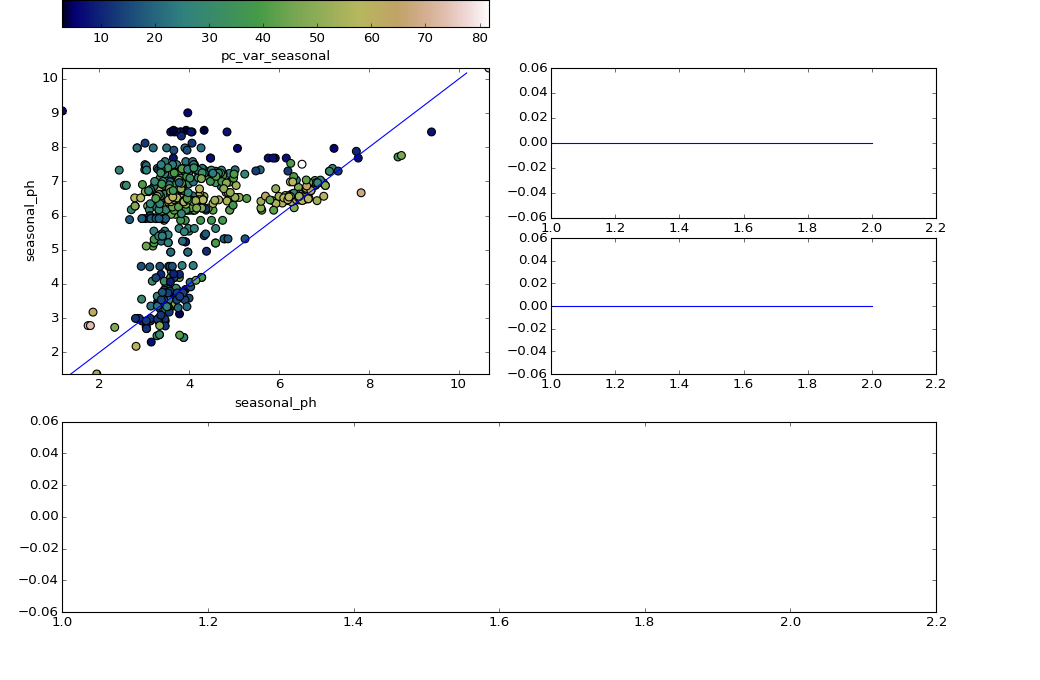

reading x
diurnal_amp
x1
y1
y type
['obs', 'modelxy', 'modelgrid']
z type
reading y
seasonal_ph
y1
seasonal_ph
seasonal_ph
seasonal_ph
seasonal_amp
seasonal_amp
seasonal_ph
seasonal_ph
seasonal_ph
seasonal_ph
seasonal_ph
mean
pc_var_full
pc_var_seasonal
z type
pc_var_seasonal
pc_var_seasonal
pc_var_full
z type
pc_var_full
seasonal_ph
z type
seasonal_ph
z type
seasonal_ph
seasonal_ph
seasonal_ph
pc_var_seasonal


In [8]:
display(layout)

fig =plt.figure(figsize=(13.0,8.5))
fig.patch.set_facecolor('white')
gs1 = gridspec.GridSpec(4, 4)
gs1.update(left=0.06,right=0.47,bottom=0.45,wspace=0.03)
ax1 = plt.subplot(gs1[:,:])
gs2 = gridspec.GridSpec(4, 4)
gs2.update(left=0.06,top=0.38,wspace=0.03)
ax2 = plt.subplot(gs2[:,:]) 
gs3 = gridspec.GridSpec(4, 4)
gs3.update(left=0.53,bottom=0.68,wspace=0.03)
ax3 = plt.subplot(gs3[:,:])         
gs4 = gridspec.GridSpec(4, 4)
gs4.update(left=0.53,top=0.65,bottom=0.45,wspace=0.03)
ax4 = plt.subplot(gs4[:,:]) 

#setup plots 
#xy plot
p1 = ax1.scatter([1,2],[1,2],s=50,c=[1,2],cmap=plt.cm.gist_earth,vmin=np.min([1,2]),vmax=np.max([1,2]),picker=1)

#ts plot
p2, = ax2.plot([1,2],[0,0])
             
#diurnal periodic plot
p3, = ax3.plot([1,2],[0,0])
             
#seasonal periodic plot
p4, = ax4.plot([1,2],[0,0])

#cb
cbar_ax = fig.add_axes([0.06, 0.96, 0.41, 0.04])
cb = fig.colorbar(p1, orientation = 'horizontal', cax=cbar_ax,label='')

def onpick(event):
    ax2.cla()
    
    ind = event.ind[0]
    
    #time series
    x_ts_i = x_ts_g[ind]
    x_ts_i[x_ts_i < 0] = np.NaN
    y_ts_i = y_ts_g[ind]
    y_ts_i[y_ts_i < 0] = np.NaN
    ax2.plot(datetime_time,x_ts_i,color='black')
    ax2.plot(datetime_time,y_ts_i,color='red')
    ax2.set_xlim(np.min(datetime_time),np.max(datetime_time))
    ax2.set_ylim(np.nanmin(x_ts_i)-1,np.nanmax(x_ts_i)+1)
    #ax2.set_ylim(np.nanmin(np.append(x_ts_i,y_ts_i)-1),np.nanmax(np.append(x_ts_i,y_ts_i)+1))
    ax2.set_title('%s Lat:%s Lon:%s Alt:%s'%(refs_g[ind],np.round(lats_g[ind],2),np.round(lons_g[ind],2),np.round(alt_g[ind],2)),loc='right')
    
    #diurnal waveform
    #x_d_i = x_diurnal_ave_waveform[ind,:]
    #p3.set_ydata(x_d_i)
    #ax3.set_ylim(np.nanmin(x_d_i)-1,np.nanmax(x_d_i)+1)

    #seasonal_waveform
    #x_s_i = x_seasonal_waveform[ind,:]
    #p4.set_ydata(x_s_i)
    #ax4.set_ylim(np.nanmin(x_s_i)-1,np.nanmax(x_s_i)+1)

    fig.canvas.draw()

def update_plot(x,y,z,x_param_name,y_param_name,z_param_name):
    #clear scatter plot
    ax1.cla()
    #plot new scatter
    if '_ph' not in z_param_name:
        ax1.scatter(x,y,s=50,c=z,picker=1,vmin=np.min(z),vmax=np.max(z),cmap=plt.cm.gist_earth)
        #change colorbar range
        cb.set_clim(vmin=np.min(z),vmax=np.max(z)) 
        #set colormap
        cb.set_cmap(plt.cm.gist_earth)
    else:
        z_min = 0
        if 'diurnal' in z_param_name.lower():
            z_max = 24
            #change colorbar range
            cb.set_clim(vmin=z_min,vmax=z_max)
        elif 'seasonal' in z_param_name.lower():
            z_max = 12
            #change colorbar range
            cb.set_clim(vmin=z_min,vmax=z_max)
        ax1.scatter(x,y,s=50,c=z,picker=1,vmin=z_min,vmax=z_max,cmap=plt.cm.hsv)
        
        #set colormap
        cb.set_cmap(plt.cm.hsv)                    
    
    #set xy axis limits
    ax1.set_xlim(np.min(x),np.max(x))
    ax1.set_ylim(np.min(y),np.max(y))

    one_to_one_line = np.arange(np.min(np.append(x,y)),np.max(np.append(x,y)),1.)
    
    ax1.plot(one_to_one_line,one_to_one_line)
    
    #set colorbar label
    cb.set_label(z_param_name)
    #set axis labels
    ax1.set_xlabel(x_param_name)
    ax1.set_ylabel(y_param_name)
    #redraw
    cb.draw_all() 
    fig.canvas.draw() 
    
data_update('')

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()